# MobileNet V1 模型总结

## 关键创新点

### 1. 深度可分离卷积（Depthwise Separable Convolution）
- 将标准卷积分解为两个独立操作：
  - **Depthwise Convolution（逐通道卷积）**：对每个输入通道单独进行卷积操作。
  - **Pointwise Convolution（逐点卷积）**：使用 `1x1` 卷积融合不同通道的信息。
- 大幅减少了计算量和参数数量，适用于移动端和嵌入式设备。这一点和新出的MLP-Mixer的结构及其接近.

### 2. 轻量化设计
- 在保证准确率的前提下，通过减少冗余计算实现高效推理。
- 相比传统卷积网络（如VGG、Inception等），模型大小显著减小。

### 3. 宽度乘子（Width Multiplier）
- 引入超参数 `α ∈ (0,1]` 控制输入输出通道数，进一步压缩模型。
- 可以在精度与速度之间做权衡，提升部署灵活性。

### 4. 分辨率乘子（Resolution Multiplier）
- 控制输入图像的分辨率，作为另一个控制模型复杂度的参数。
- 允许根据设备性能调整输入尺寸，从而影响整体计算量。

### 5. 模块化结构
- 整体网络由多个堆叠的深度可分离卷积模块构成，便于复用和扩展。

---

## 缺点与局限性

### 1. 精度略低于标准模型
- 在相同数据集下，相比 ResNet、Inception 等大型模型，在 Top-1 准确率上略有下降。

### 2. 感受野受限
- 使用较多的小卷积核（如 3x3）和深度卷积，可能限制了特征提取的感受野范围。

### 3. 依赖手动设计
- 网络结构是人工设计的，没有像后续版本（如 MobileNetV2、NASNet）那样利用神经网络架构搜索（NAS）来优化性能。

### 4. 信息流动效率较低
- 深度可分离卷积可能导致特征表达能力受限，特别是在高层语义任务中表现不如密集连接的网络。

---

## 总结

MobileNet V1 是一个开创性的轻量级卷积神经网络，其核心思想 —— **深度可分离卷积**，为后续轻量化模型的发展奠定了基础。尽管它在精度和表达能力上有所妥协，但在移动设备和边缘计算场景中具有重要的应用价值。

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory
from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader

TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
train_dataset_transforms = transforms.Compose(
    [
        RandomResize([256, 296, 384]),  # 随机在三个size中选择一个进行resize
        transforms.RandomRotation(10),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=train_dataset_transforms,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=val_dataset_transforms,
)


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader

In [3]:
from hdd.models.cnn.mobilenet_v1 import MobileNetV1
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier,
    lr=1e-3,
    weight_decay=1e-5,
    max_epochs=150,
) -> tuple[MobileNetV1, dict[str, list[float]]]:
    net = MobileNetV1(num_classes=10, width_multiplier=width_multiplier).to(DEVICE)
    print(f"#Parameter: {count_trainable_parameter(net)}")
    criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, max_epochs, eta_min=lr / 100
    )
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return net, training_stats


train_dataloader, val_dataloader = build_dataloader(128, train_dataset, val_dataset)

net, width_multiplier_1 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=1,
    lr=0.01,
    weight_decay=0,
    max_epochs=150,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 3228170
Epoch: 1/150 Train Loss: 2.2419 Accuracy: 0.2369 Time: 7.72386  | Val Loss: 3.4601 Accuracy: 0.2211
Epoch: 2/150 Train Loss: 1.7932 Accuracy: 0.4290 Time: 7.46382  | Val Loss: 2.1566 Accuracy: 0.3949
Epoch: 3/150 Train Loss: 1.6094 Accuracy: 0.5266 Time: 7.46969  | Val Loss: 1.6864 Accuracy: 0.5340
Epoch: 4/150 Train Loss: 1.4884 Accuracy: 0.5849 Time: 7.52314  | Val Loss: 1.7090 Accuracy: 0.5427
Epoch: 5/150 Train Loss: 1.3896 Accuracy: 0.6295 Time: 7.44157  | Val Loss: 1.5121 Accuracy: 0.6183
Epoch: 6/150 Train Loss: 1.3173 Accuracy: 0.6584 Time: 7.50764  | Val Loss: 1.3468 Accuracy: 0.6566
Epoch: 7/150 Train Loss: 1.2714 Accuracy: 0.6805 Time: 7.50115  | Val Loss: 1.8430 Accuracy: 0.5529
Epoch: 8/150 Train Loss: 1.2278 Accuracy: 0.7011 Time: 7.53017  | Val Loss: 1.1906 Accuracy: 0.7215
Epoch: 9/150 Train Loss: 1.1849 Accuracy: 0.7184 Time: 7.48540  | Val Loss: 1.3151 Accuracy: 0.6841
Epoch: 10/150 Train Loss: 1.1555 Accuracy: 0.7334 Time: 7.78427  | Val Loss: 1.1

In [4]:
net, width_multiplier_75 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=0.75,
    lr=0.01,
    weight_decay=0,
    max_epochs=150,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 1832458
Epoch: 1/150 Train Loss: 2.2076 Accuracy: 0.2331 Time: 6.14311  | Val Loss: 1.9852 Accuracy: 0.3088
Epoch: 2/150 Train Loss: 1.8816 Accuracy: 0.3758 Time: 6.16040  | Val Loss: 2.3118 Accuracy: 0.3236
Epoch: 3/150 Train Loss: 1.6880 Accuracy: 0.4654 Time: 6.16418  | Val Loss: 1.6775 Accuracy: 0.4889
Epoch: 4/150 Train Loss: 1.5846 Accuracy: 0.5327 Time: 6.13031  | Val Loss: 1.5169 Accuracy: 0.5666
Epoch: 5/150 Train Loss: 1.4706 Accuracy: 0.5888 Time: 6.11414  | Val Loss: 1.8738 Accuracy: 0.4851
Epoch: 6/150 Train Loss: 1.3825 Accuracy: 0.6284 Time: 6.16415  | Val Loss: 1.4884 Accuracy: 0.6196
Epoch: 7/150 Train Loss: 1.3139 Accuracy: 0.6586 Time: 6.15448  | Val Loss: 1.3594 Accuracy: 0.6596
Epoch: 8/150 Train Loss: 1.2589 Accuracy: 0.6858 Time: 6.16214  | Val Loss: 1.5748 Accuracy: 0.5608
Epoch: 9/150 Train Loss: 1.2157 Accuracy: 0.7042 Time: 6.13283  | Val Loss: 1.1967 Accuracy: 0.7118
Epoch: 10/150 Train Loss: 1.1686 Accuracy: 0.7272 Time: 6.20370  | Val Loss: 1.2

In [5]:
net, width_multiplier_50 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=0.5,
    lr=0.01,
    weight_decay=0,
    max_epochs=150,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 829194
Epoch: 1/150 Train Loss: 2.0650 Accuracy: 0.2916 Time: 4.99818  | Val Loss: 2.5460 Accuracy: 0.3175
Epoch: 2/150 Train Loss: 1.7556 Accuracy: 0.4443 Time: 5.01246  | Val Loss: 1.9894 Accuracy: 0.3664
Epoch: 3/150 Train Loss: 1.6251 Accuracy: 0.5138 Time: 4.96184  | Val Loss: 1.8722 Accuracy: 0.4204
Epoch: 4/150 Train Loss: 1.5365 Accuracy: 0.5635 Time: 5.00987  | Val Loss: 1.5179 Accuracy: 0.5725
Epoch: 5/150 Train Loss: 1.4467 Accuracy: 0.5976 Time: 4.97376  | Val Loss: 1.5992 Accuracy: 0.5748
Epoch: 6/150 Train Loss: 1.3871 Accuracy: 0.6272 Time: 5.01516  | Val Loss: 1.2850 Accuracy: 0.6767
Epoch: 7/150 Train Loss: 1.3355 Accuracy: 0.6521 Time: 5.01075  | Val Loss: 1.6096 Accuracy: 0.5462
Epoch: 8/150 Train Loss: 1.2736 Accuracy: 0.6843 Time: 5.03543  | Val Loss: 1.4415 Accuracy: 0.6135
Epoch: 9/150 Train Loss: 1.2301 Accuracy: 0.6973 Time: 4.98625  | Val Loss: 1.1435 Accuracy: 0.7345
Epoch: 10/150 Train Loss: 1.1991 Accuracy: 0.7152 Time: 5.00523  | Val Loss: 1.30

In [6]:
net, width_multiplier_25 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=0.25,
    lr=0.01,
    weight_decay=0,
    max_epochs=150,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 218378
Epoch: 1/150 Train Loss: 2.0723 Accuracy: 0.2748 Time: 4.24569  | Val Loss: 3.4826 Accuracy: 0.2413
Epoch: 2/150 Train Loss: 1.7895 Accuracy: 0.4374 Time: 4.20252  | Val Loss: 2.2487 Accuracy: 0.3327
Epoch: 3/150 Train Loss: 1.6338 Accuracy: 0.5110 Time: 4.25970  | Val Loss: 1.8288 Accuracy: 0.4836
Epoch: 4/150 Train Loss: 1.5502 Accuracy: 0.5540 Time: 4.20291  | Val Loss: 1.7197 Accuracy: 0.4675
Epoch: 5/150 Train Loss: 1.4665 Accuracy: 0.5880 Time: 4.20500  | Val Loss: 1.6136 Accuracy: 0.5432
Epoch: 6/150 Train Loss: 1.4112 Accuracy: 0.6140 Time: 4.23587  | Val Loss: 1.5477 Accuracy: 0.5829
Epoch: 7/150 Train Loss: 1.3760 Accuracy: 0.6355 Time: 4.25241  | Val Loss: 1.5485 Accuracy: 0.5837
Epoch: 8/150 Train Loss: 1.3208 Accuracy: 0.6552 Time: 4.21400  | Val Loss: 1.8580 Accuracy: 0.5259
Epoch: 9/150 Train Loss: 1.3002 Accuracy: 0.6635 Time: 4.18240  | Val Loss: 1.3314 Accuracy: 0.6660
Epoch: 10/150 Train Loss: 1.2497 Accuracy: 0.6826 Time: 4.26280  | Val Loss: 1.35

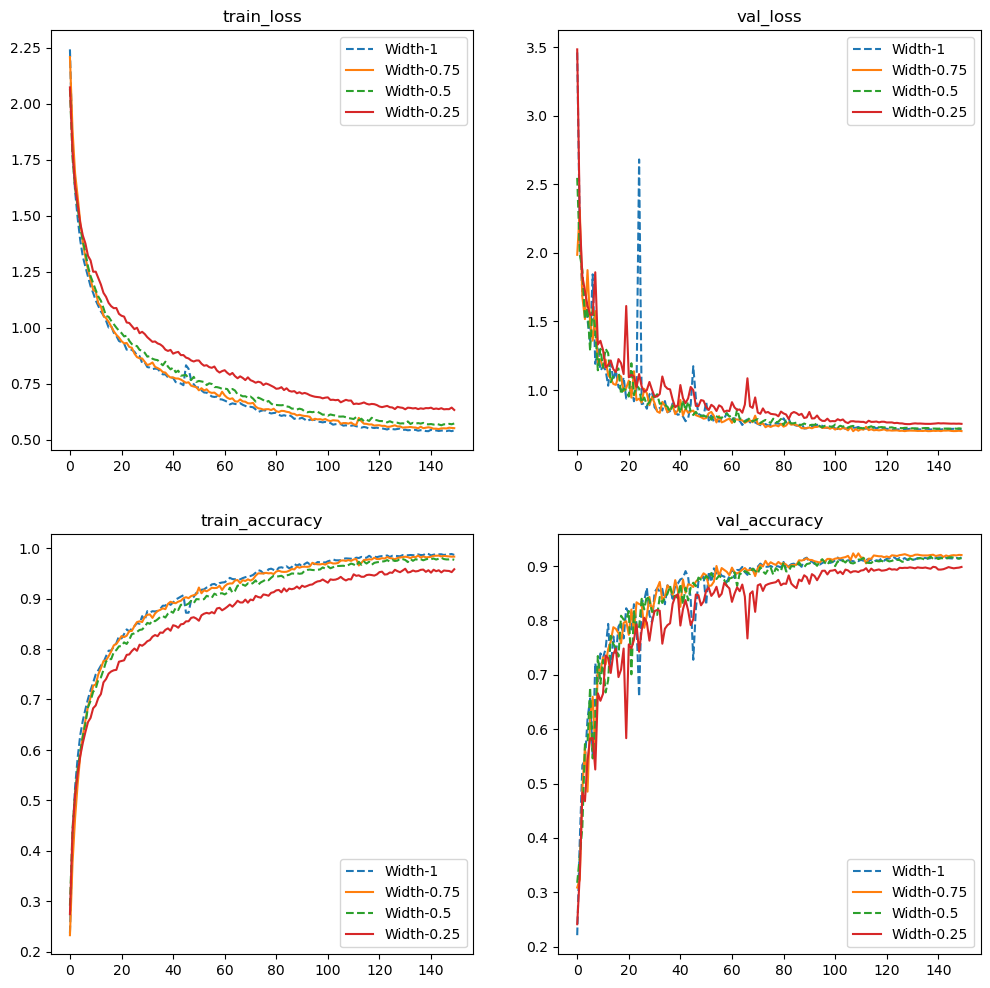

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = width_multiplier_1.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(width_multiplier_1[field], label="Width-1", linestyle="--")
    plt.plot(width_multiplier_75[field], label="Width-0.75")
    plt.plot(width_multiplier_50[field], label="Width-0.5", linestyle="--")
    plt.plot(width_multiplier_25[field], label="Width-0.25", linestyle="-")
    plt.legend()
    plt.title(field)